# Example

## Read data

### 1. Summary Statistics

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import glob
import json
from pprint import pprint

There are two folders. The folder `data/statistics/` contains summarized statistics with median, mode, mean, std and quantiles for the smoothed density estimate and for each of the smooth contexts. The folder `data/densities` contains the full smooth densities of the overall distribution and per each context. 

#### Summary Statistics


Load the data as a dictionary of dictionaries. The first key corresponds to the object and second key to the attribute.

In [2]:
fpath = "./data/statistics/*.json"
files = glob.glob(fpath)

dat_stats = defaultdict(dict)
for batch_file in tqdm(files):
    with open(batch_file, "r") as io:
        for D in json.load(io):
            obj = D['obj']
            dim = D['dim']
            dat_stats[obj][dim] = D

4%|▍         | 129/3196 [00:05<02:08, 23.84it/s]


KeyboardInterrupt: 

To know the attributes available for an object one can do:

In [17]:
dat_stats['peanut'].keys()

dict_keys(['VOLUME', 'DURATION', 'CURRENCY', 'LENGTH', 'ENERGY', 'MASS'])

Here's an example of the summary stats of an object

In [13]:
pprint(dat_stats['peanut']['LENGTH'])

{'contexts_stats': [{'iqr': 0.08068547775156193,
                     'mean': 0.2767042971528648,
                     'median': 0.2746377657095261,
                     'mode': 0.23724240800809487,
                     'quantiles': [0.20493901364685682,
                                   0.20493901364685682,
                                   0.215185966274198,
                                   0.22594527002299708,
                                   0.23724240800809487,
                                   0.2746377657095261,
                                   0.3179278857596568,
                                   0.35051519499468503,
                                   0.3680409773936405,
                                   0.3869260625139241,
                                   0.426053717574983],
                     'std': 0.051424714408284264},
                    {'iqr': 0.07404044625723943,
                     'mean': 0.5099276076900934,
                     'median': 0.5178708699

Here's the full full description of the schema for each **(obj, dim)** pair:

- **obj**: str
- **dim**: str
- **n_contexts**: int
- **density**: dict, statistics for global density
- **contexts**: List(dict), statistics the densities of each context
- **weights_nn**: List(float), weight of each context as measured by the neural network model
- **weights_counts**: List(float), weight of each context as assigning the counts of each bin in the original data proportionally to the value of each density evaluated at the bin

The dicionary of statistics consists of the following keys:
- **iqr**: float, interquantile range, difference between the first and third quartile
- **median**: float
- **mode**: float, center point of the bin with highest density value
- **quantile**: List(float), correspoding to 1%, 2.5%, 5%, 10%, 25%, 50%, 75%, 90%, 95%, 97.5% and 99%.
- **mean**: float
- **std**: float

### 2. Densities 



Now the full densities

In [3]:
fpath = "./data/densities/*.json"
files = glob.glob(fpath)

dat_dens = defaultdict(dict)
for batch_file in tqdm(files):
    with open(batch_file, "r") as io:
        for D in json.load(io):
            obj = D['obj']
            dim = D['dim']
            dat_dens[obj][dim] = D

100%|██████████| 3196/3196 [12:04<00:00,  4.41it/s]


Let's look at the keys

In [38]:
D = dat_dens['peanut']['LENGTH']
D.keys()

dict_keys(['n_bins', 'density', 'peaks', 'n_contexts', 'contexts', 'wts_counts', 'wts_nn', 'counts', 'loglower', 'logupper', 'obj', 'dim'])

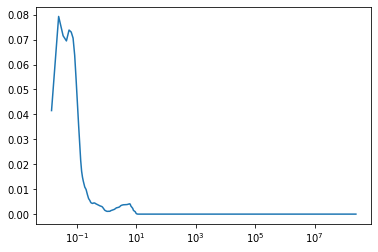

In [40]:
import matplotlib.pyplot as plt


y = np.array(D['density'])
obs = np.array(D['counts'])
x = 10.0 ** (0.5 * np.array(D['loglower']) + 0.5 * np.array(D['logupper']))

plt.plot(x, y)
plt.xscale("log")

It's easy to obtain label predictions per bin using the following function

In [42]:
import numpy as np
import pandas as pd

def label_predict(D: dict):
    n_contexts = D['n_contexts']
    densities = np.array(D['contexts']) + 1e-6
    densities /= densities.sum(0, keepdims=True) 
    densities = {f'context_{j}': d
                 for j, d in enumerate(densities)}
    densities['lower'] = 10 ** np.array(D['loglower'])
    densities['upper'] = 10 ** np.array(D['logupper'])
    densities = pd.DataFrame(densities)
    return densities

In [43]:
D = dat_dens['peanut']['LENGTH']
pred = label_predict(D)
pred.head()

,context_0,context_1,lower,upper
0,0.986888,0.013112,0.01,0.02
1,0.987509,0.012491,0.02,0.03
2,0.990730,0.009270,0.03,0.04
3,0.997124,0.002876,0.04,0.05
4,0.994748,0.005252,0.05,0.06


Text(0.5, 0, 'bin')

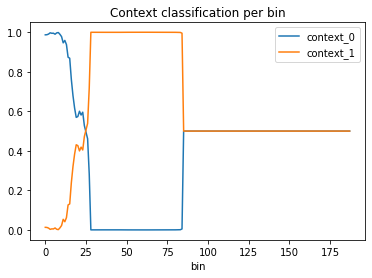

In [44]:
pred.plot(y=['context_0', 'context_1'])
plt.title("Context classification per bin")
plt.xlabel("bin")